# [project] 흡연상태와 음주여부에 따른 건강상태 분석

**<font color=red>추가적인 정보의 경우 부록으로 따로 첨부함</font>**

## 1. 필요 라이브러리 임포트 및 한글폰트 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# 그래프에 한글이 나오지 않을 경우 
# 아래의 코드를 한번 더 실행 후 그래프 코드만 재실행
plt.rcParams['font.family'] = 'ONE Mobile'

## 2. 데이터 불러오기

In [3]:
# 22년도와 21년도 데이터
data_2022 = pd.read_csv('국민건강보험공단_건강검진정보_20221231.CSV')
data_2021 = pd.read_csv('국민건강보험공단_건강검진정보_20211231_수정.CSV')

# 병합
df = pd.concat([data_2022, data_2021], axis=0, join='inner', ignore_index=True)

In [4]:
df.head(2)

,기준년도,가입자일련번호,시도코드,성별,연령대코드(5세단위),신장(5cm단위),체중(5kg단위),허리둘레,시력(좌),시력(우),...,요단백,혈청크레아티닌,혈청지오티(AST),혈청지피티(ALT),감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석
0,2022,702763,41,2,14,160,75,89.0,1.0,1.0,...,1.0,0.8,25.0,20.0,15.0,1.0,0.0,0,NaN,NaN
1,2022,765435,41,2,9,150,45,68.0,1.0,1.0,...,1.0,0.8,19.0,10.0,7.0,1.0,1.0,0,NaN,NaN


## 3. 데이터 정제

### 3.1 각 열의 값이 코드(숫자)로 되어 있으므로 알아보기 쉽게 문자열로 변경

In [5]:
# 데이터를 알아보기 쉽게 변경. 코드 -> 문자열 
def code_to_str(df):
    sex = {1:'남자', 2:'여자'}
    df['성별'] = df['성별'].map(sex)

    # 20세 이상이 대상이므로 연령대 코드는 5부터 시작
    age = {5:'20~24세', 6:'25~29세', 7:'30~34세', 8:'35~39세', 
           9:'40~44세', 10:'45~49세', 11:'50~54세', 12:'55~59세', 13:'60~64세', 
           14:'65~69세', 15:'70~74세', 16:'75~79세', 17:'80~84세', 18:'85세+'}
    df['연령대코드(5세단위)'] = df['연령대코드(5세단위)'].map(age)

    region = {11:'서울특별시', 26:'부산광역시', 27:'대구광역시',  28:'인천광역시', 
              29:'광주광역시', 30:'대전광역시', 31:'울산광역시', 36:'세종특별자치시', 
              41:'경기도', 42:'강원도', 43:'충청북도', 44:'충청남도', 45:'전라북도', 
              46:'전라남도', 47:'경상북도', 48:'경상남도', 49:'제주특별자치도'}
    df['시도코드'] = df['시도코드'].map(region)

    smoke = {1:'비흡연자', 2:'이전에 피웠으나 끊었다', 3:'흡연자'}
    df['흡연상태'] = df['흡연상태'].map(smoke)

    drunk = {0:'마시지 않는다', 1:'마신다'}
    df['음주여부'] = df['음주여부'].map(drunk)
    
    return df

df_str = code_to_str(df)

In [6]:
df_str.head(2)

,기준년도,가입자일련번호,시도코드,성별,연령대코드(5세단위),신장(5cm단위),체중(5kg단위),허리둘레,시력(좌),시력(우),...,요단백,혈청크레아티닌,혈청지오티(AST),혈청지피티(ALT),감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석
0,2022,702763,경기도,여자,65~69세,160,75,89.0,1.0,1.0,...,1.0,0.8,25.0,20.0,15.0,비흡연자,마시지 않는다,0,NaN,NaN
1,2022,765435,경기도,여자,40~44세,150,45,68.0,1.0,1.0,...,1.0,0.8,19.0,10.0,7.0,비흡연자,마신다,0,NaN,NaN


### 3.2 데이터 사용 위한 전처리

In [7]:
def fixing(df):
    # 열 이름 변경
    df.rename(columns={'시도코드':'지역', '연령대코드(5세단위)':'연령대', '신장(5cm단위)':'신장', 
                       '체중(5kg단위)':'체중', '수축기혈압':'최고혈압', '이완기혈압':'최저혈압'}, inplace=True)

    # BMI열 추가
    df['BMI'] = round(df['체중'] / ((df['신장'] /100)**2), 2)

    # 비만분류 열 추가를 위한 함수 (참조1을 기준으로)
    def bmi_col(df):
        if df < 18.5:
            return '저체중'
        elif (df >= 18.5) & (df < 23):
            return '정상'
        elif (df >= 23) & (df < 25):
            return '과체중'
        elif (df >= 25) & (df < 30):
            return '1단계 비만'
        elif (df >= 30) & (df < 35):
            return '2단계 비만'
        elif df >= 35:
            return '3단계 비만'

    # 비만분류 열 추가
    df['비만분류'] = df['BMI'].apply(bmi_col)

    # 필요없는 열 제거
    df_del_col = df.drop(['가입자일련번호', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '총콜레스테롤',
                          '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
                          '구강검진수검여부', '치아우식증유무', '치석'], axis=1)

    # 흡연상태의 '이전에 피웠으나 끊었다' 값을 흡연자로 변경 (참조2에 근거하여)
    df_del_col = df_del_col.replace({'흡연상태': '이전에 피웠으나 끊었다'}, '흡연자')
    
    return df_del_col

df_del_col = fixing(df_str)

    참조1 : 대한비만학회 제공 "비만 치료지침(2022 8판)" 기준
    
    참조2 : 황영희, 오지현. (2018). 흡연중단자에서 흡연기간, 흡연량, 금연기간이 폐기능에 미치는 영향: 
            2016년 국민건강영양조사 활용. 기초간호자연과학회지 , 20(4), 214-220.

In [8]:
# 전처리 후 데이터프레임
df_del_col.head(2)

,기준년도,지역,성별,연령대,신장,체중,허리둘레,최고혈압,최저혈압,식전혈당(공복혈당),혈청지오티(AST),혈청지피티(ALT),감마지티피,흡연상태,음주여부,BMI,비만분류
0,2022,경기도,여자,65~69세,160,75,89.0,127.0,73.0,84.0,25.0,20.0,15.0,비흡연자,마시지 않는다,29.3,1단계 비만
1,2022,경기도,여자,40~44세,150,45,68.0,127.0,75.0,85.0,19.0,10.0,7.0,비흡연자,마신다,20.0,정상


### 3.3 결측치 처리

In [9]:
df_del_col.shape

(2000000, 17)

In [10]:
df_del_col.isna().sum()

기준년도              0
지역                0
성별                0
연령대               0
신장                0
체중                0
허리둘레            781
최고혈압          10913
최저혈압          10914
식전혈당(공복혈당)    11029
혈청지오티(AST)    11025
혈청지피티(ALT)    11025
감마지티피         11024
흡연상태            433
음주여부            244
BMI               0
비만분류              0
dtype: int64

In [11]:
'''200만개의 데이터중 수축기혈압, 혈청지오티 등은 약 11000개, 
흡연상태, 음주여부는 200~400개 정도의 결측치이므로 분석의 정확성을위해 제외'''

df_del_row = df_del_col.dropna().reset_index(drop=True)
df_del_row.isna().sum()

기준년도          0
지역            0
성별            0
연령대           0
신장            0
체중            0
허리둘레          0
최고혈압          0
최저혈압          0
식전혈당(공복혈당)    0
혈청지오티(AST)    0
혈청지피티(ALT)    0
감마지티피         0
흡연상태          0
음주여부          0
BMI           0
비만분류          0
dtype: int64

In [12]:
df_bmi = df_del_row

## 4. 데이터 경향 확인

In [13]:
# 경고창 없애기
import warnings
warnings.filterwarnings('ignore')
# 그래프 배경
sns.set_style('darkgrid')

### 4.1 연령대별 BMI지수 분포

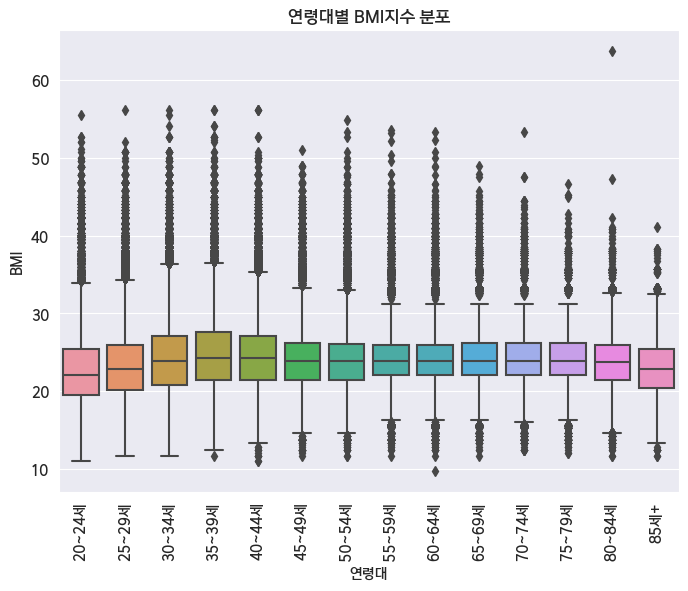

In [29]:
plt.figure(figsize=(8, 6))
plt.title('연령대별 BMI지수 분포')
sns.boxplot(data=df_bmi.sort_values('연령대'), x='연령대', y='BMI')
plt.xticks(rotation='vertical')
plt.show()

### 4.2 연령대 별 흡연상태 및 음주여부 비율

In [15]:
# 연령대 및 흡연상태 인원수 데이터프레임
df_smoke = df_bmi.groupby(['연령대', '흡연상태']).size().reset_index(name='흡연상태 별 인원수(명)')

# 연령대 전체 인원수 및 연령대 별 비율 열 추가
rep = df_bmi.groupby('연령대').size().values
rep = np.repeat(rep, 2)
df_smoke['연령대 전체 인원수'] = rep
df_smoke['연령대 별 비율'] = round(df_smoke['흡연상태 별 인원수(명)'] / df_smoke['연령대 전체 인원수'] * 100, 2)
df_smoke_rate = df_smoke.set_index(['연령대'])

# 연령대 및 음주여부 인원수 데이터프레임
df_drunk = df_bmi.groupby(['연령대', '음주여부']).size().reset_index(name='음주여부 별 인원수(명)')

# 연령대 전체 인원수 및 연령대 별 비율 열 추가
df_drunk['연령대 전체 인원수'] = rep
df_drunk['연령대 별 비율'] = round(df_drunk['음주여부 별 인원수(명)'] / df_drunk['연령대 전체 인원수'] * 100, 2)
df_drunk_rate = df_drunk.set_index(['연령대'])

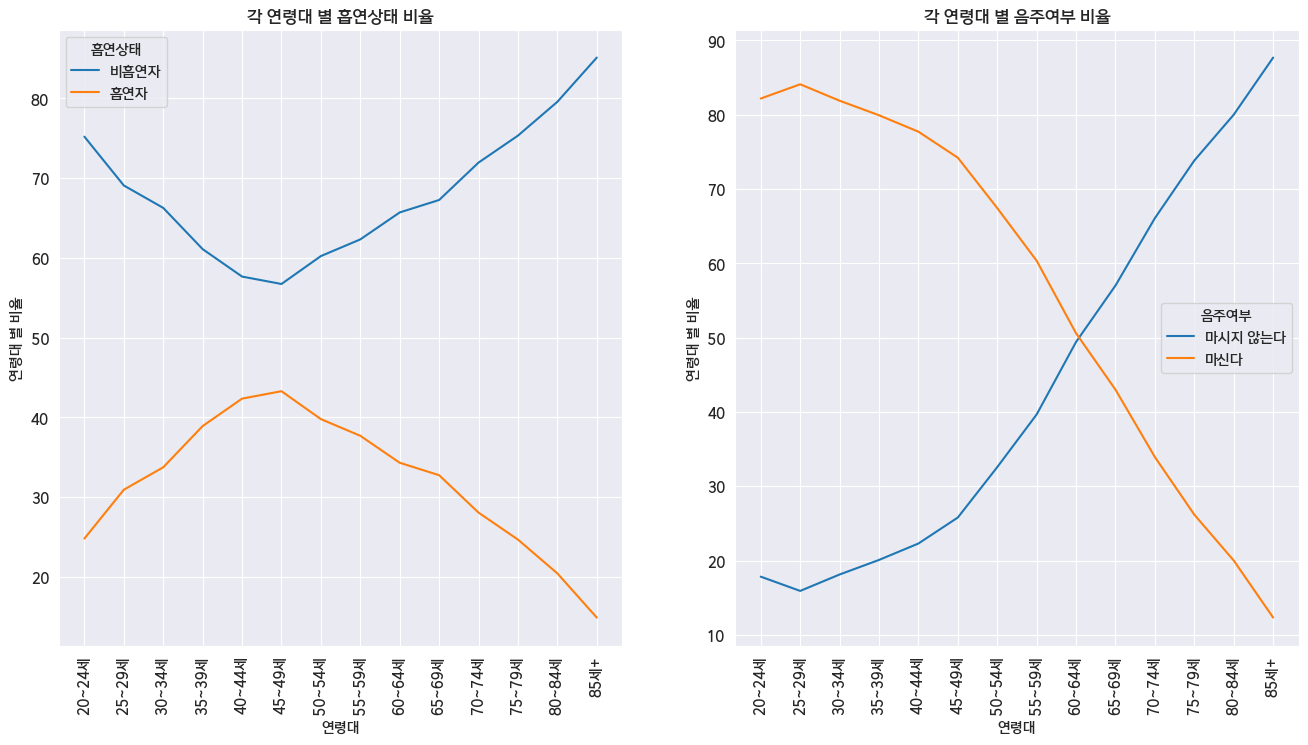

In [30]:
plt.figure(figsize=(16, 8))

# 각 연령대 별 흡연상태 비율 그래프
plt.subplot(121)
plt.title('각 연령대 별 흡연상태 비율')
sns.lineplot(x=df_smoke_rate.index, y=df_smoke_rate['연령대 별 비율'], hue=df_smoke_rate['흡연상태'])
plt.xticks(rotation='vertical')

# 각 연령대 별 음주여부 비율 그래프
plt.subplot(122)
plt.title('각 연령대 별 음주여부 비율')
sns.lineplot(x=df_drunk_rate.index, y=df_drunk_rate['연령대 별 비율'], hue=df_drunk_rate['음주여부'])
plt.xticks(rotation='vertical')
plt.show()

### 4.3 성별에 따른 음주여부와 흡연여부 비율 비교

#### 4.3.1 음주여부 비율 데이터프레임 작성

In [17]:
# 성별과 음주여부로 그룹화한 인원수 데이터프레임
df_drunk_sex = df_bmi.groupby(['성별', '음주여부']).size().reset_index(name='음주여부 별 인원수(명)')

# 성별 전체 인원수 및 성별 별 비율 열 추가
rep_sex = df_bmi.groupby('성별').size().values
rep_sex = np.repeat(rep_sex, 2)
df_drunk_sex['성별 전체 인원수'] = rep_sex
df_drunk_sex['성별 별 비율'] = round(df_drunk_sex['음주여부 별 인원수(명)'] / df_drunk_sex['성별 전체 인원수'] * 100, 2)
# 성별 컬럼을 인덱스로
df_drunk_sex.set_index(['성별'], inplace=True)

# 음주여부 전체 인원수와 비율
df_total_drunk = df_bmi.groupby('음주여부').size().reset_index(name='음주여부 별 인원수(명)')
df_total_drunk['성별'] = '전체'
df_total_drunk['성별 전체 인원수'] = len(df_bmi)
df_total_drunk['성별 별 비율'] = round(df_total_drunk['음주여부 별 인원수(명)'] / df_total_drunk['성별 전체 인원수'] * 100, 2)
# 성별 컬럼을 인덱스로
df_total_drunk.set_index(['성별'], inplace=True)

# 성별로 나눈 데이터프레임과 전체 데이터 프레임 병합
concat_drunk_sex = pd.concat([df_drunk_sex, df_total_drunk], axis=0, join='inner')

#### 4.3.2 흡연상태 비율 데이터프레임 작성

In [18]:
# 성별과 흡연상태로 그룹화한 인원수 데이터프레임
df_smoke_sex = df_bmi.groupby(['성별', '흡연상태']).size().reset_index(name='흡연상태 별 인원수(명)')

# 성별 전체 인원수 및 성별 별 비율 열 추가
df_smoke_sex['성별 전체 인원수'] = rep_sex   # 위에서 만든 rep_sex 사용
df_smoke_sex['성별 별 비율'] = round(df_smoke_sex['흡연상태 별 인원수(명)'] / df_smoke_sex['성별 전체 인원수'] * 100, 2)
# 성별 컬럼을 인덱스로
df_smoke_sex.set_index(['성별'], inplace=True)

# 흡연상태 전체 인원수와 비율
df_total_smoke = df_bmi.groupby('흡연상태').size().reset_index(name='흡연상태 별 인원수(명)')
df_total_smoke['성별'] = '전체'
df_total_smoke['성별 전체 인원수'] = len(df_bmi)
df_total_smoke['성별 별 비율'] = round(df_total_smoke['흡연상태 별 인원수(명)'] / df_total_smoke['성별 전체 인원수'] * 100, 2)
# 성별 컬럼을 인덱스로
df_total_smoke.set_index(['성별'], inplace=True)

# 성별로 나눈 데이터프레임과 전체 데이터 프레임 병합
concat_smoke_sex = pd.concat([df_smoke_sex, df_total_smoke], axis=0, join='inner')

#### 4.3.3 성별에 따른 음주여부와 흡연상태 비율 비교 그래프

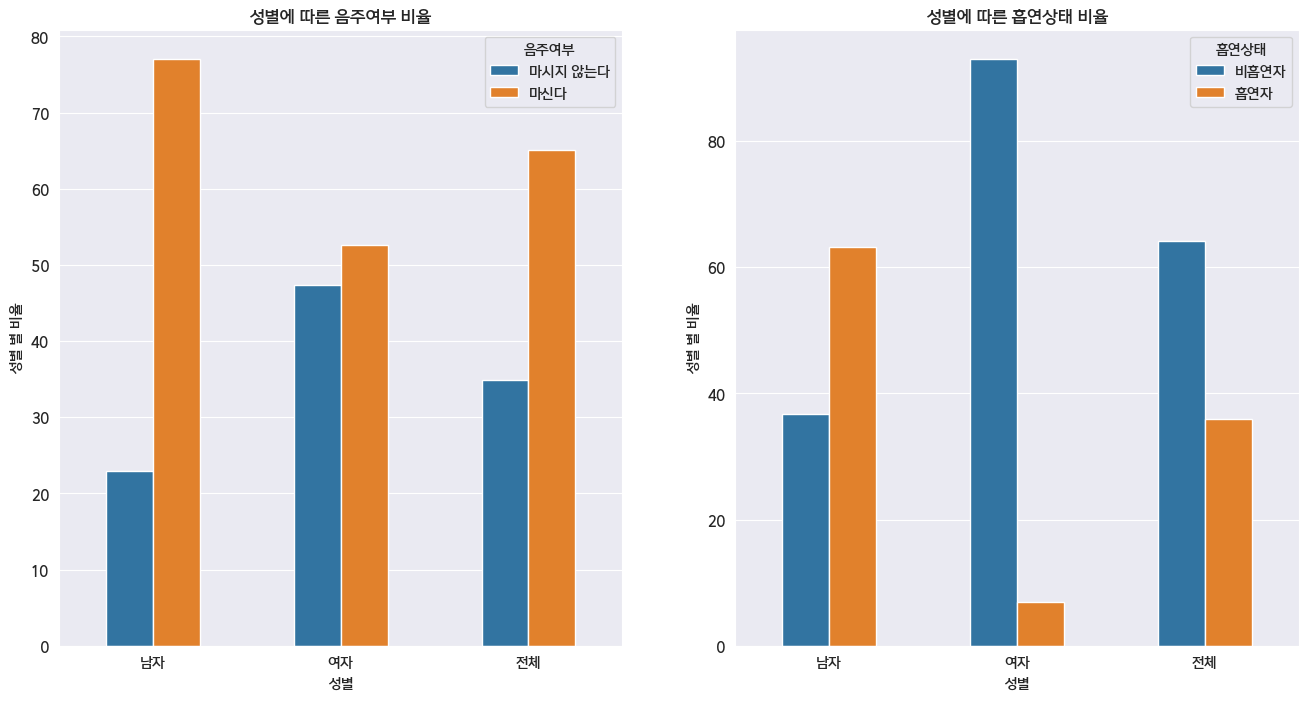

In [31]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
sns.barplot(data=concat_drunk_sex, x=concat_drunk_sex.index, y=concat_drunk_sex['성별 별 비율'], 
            hue=concat_drunk_sex['음주여부'], width=0.5)
plt.title('성별에 따른 음주여부 비율')

plt.subplot(122)
sns.barplot(data=concat_smoke_sex, x=concat_smoke_sex.index, y=concat_smoke_sex['성별 별 비율'],
            hue=concat_smoke_sex['흡연상태'], width=0.5 )
plt.title('성별에 따른 흡연상태 비율')

plt.show()

### 4.4 BMI분포 (히스토그램)

#### 4.4.1 전체 및 성별 별 BMI 분포

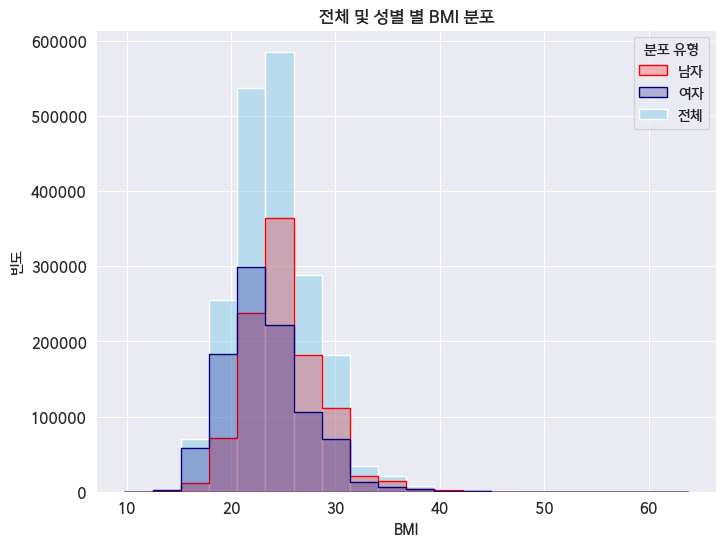

In [71]:
plt.figure(figsize=(8, 6))

sns.histplot(data=df_bmi, x='BMI', bins=20, color='skyblue', alpha=0.5)
sns.histplot(data=df_bmi, x='BMI', hue='성별', element='step', bins=20, palette=['navy', 'red'], linewidth=1)
plt.title('전체 및 성별 별 BMI 분포')
plt.xlabel('BMI')
plt.ylabel('빈도')

plt.legend(title='분포 유형', labels=['남자', '여자', '전체'])

plt.show()

#### 4.4.2 성별 별 비만분류

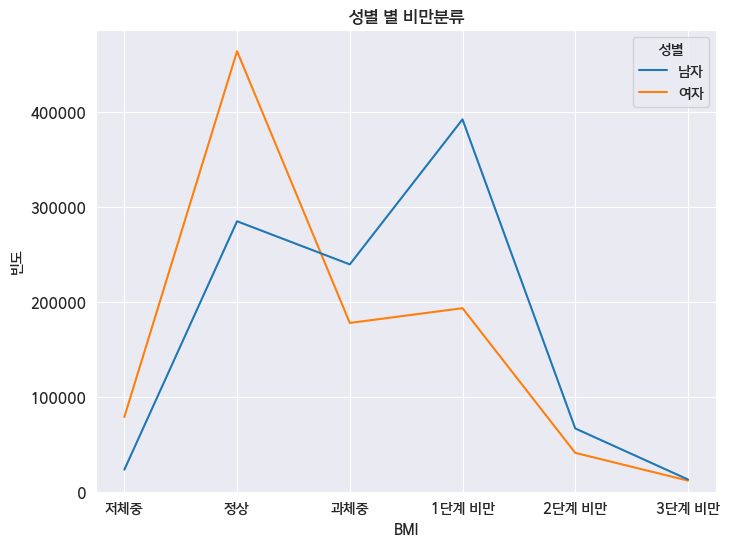

In [33]:
plt.figure(figsize=(8, 6))
plt.title('성별 별 비만분류')
sns.histplot(data=df_bmi.sort_values('BMI'), x='비만분류', hue='성별', element='poly', fill=False, bins=20)
plt.xlabel('BMI')
plt.ylabel('빈도')
plt.show()

    여자와 남자 모두 과체중 보다는 1단계 비만이 많은 경향을 보인다.
    여자는 남자에 비해 정상 체중인 사람이 많으므로 음주여부 및 흡연상태와 BMI를 비교했을 때 상관관계가 적을 수 있다.

## 5. 가설에 따른 분석

## 가설 : 흡연과 음주는 BMI 수치에 영향을 줄 것이다

    앞서 연령대별 BMI의 박스플롯에서 박스의 크기와 평균이 비교적 균일하므로 데이터가 균등하게 분포되어 있었고,
    각 연령대 별 음주여부 비율 그래프에서 60~64세를 경계로 음주를 하지않는 사람의 수가 음주를 하는 사람의 수를 추월했으므로, 
    연령대별로 비교해보는 것이 좋을 것으로 판단. 먼저 연령대 별로 BMI 평균치를 비교해본다

### 5.1 연령대별 흡연상태와 음주여부에 따른 BMI 평균치 비교

In [52]:
total = df_bmi.groupby(['흡연상태', '음주여부']).mean()['BMI'].reset_index()
df_mean_both = df_bmi.groupby(['연령대', '흡연상태', '음주여부']).mean()['BMI'].reset_index()
df_mean_both.loc[56] = ['전체 평균', '전체', '전체', df_bmi['BMI'].mean()]
    
df_mean_both['흡연_음주'] = df_mean_both.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)
df_mean_both.loc[56, '흡연_음주'] = '전체 평균'
df_mean_both.drop(['흡연상태', '음주여부'], axis=1, inplace=True)

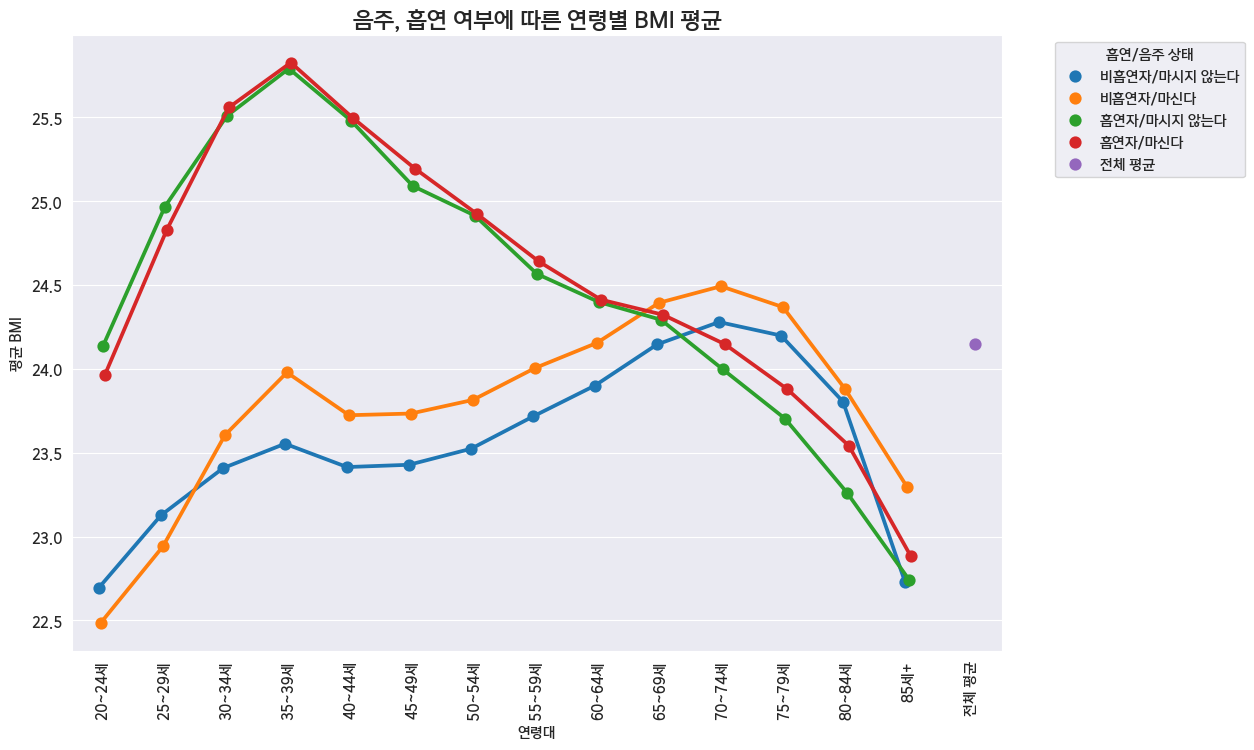

In [53]:
# 연령대별 + 전체 흡연상태와 음주여부에 따른 BMI 평균 그래프
plt.figure(figsize=(12, 8))
plt.title('음주, 흡연 여부에 따른 연령별 BMI 평균', fontsize=16)
sns.pointplot(x='연령대', y='BMI', hue='흡연_음주', data=df_mean_both, dodge=True, capsize=.1)
plt.xlabel('연령대')
plt.ylabel('평균 BMI')
plt.legend(title='흡연/음주 상태', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation='vertical')
plt.show()

    음주와 흡연 모두 하는 사람과 흡연만 하는 사람의 BMI 평균의 차이가 적고, 
    흡연만 하는 사람의 BMI가 음주만 하는 사람의 BMI보다 높다.
    
    나이대 별로는 40~44세까지는 비슷한 경향을 보이다가 
    60세~69세 부터 '비흡연자/마신다'와 '비흡연자/마시지 않는다'가 
    '흡연자/마신다'와 '흡연자/마시지 않는다'의 BMI를 추월하는 경향을 보인다
    
    70~74세 부터 BMI가 떨어지면서 85세+의 경우 다른 연령에 비해 압도적로 낮은 BMI를 보인다

### 5.2 성별 별 음주 여부 및 흡연상태에 따른 BMI평균 비교

    앞서 그린 4.4.2 '성별 별 비만분류' 그래프에서 여자가 비교적 정상체중이 많았고, 비만이 적었기 때문에
    성별을 따로 비교해봤을 때 유의미한 결과가 나올 것으로 예상.
    음주, 흡연 여부에 따른 연령별 BMI 평균을 여자와 남자 데이터로 나눠서 그려본다

In [24]:
sex_mean_both = df_bmi.groupby(['성별', '연령대', '흡연상태', '음주여부']).mean()['BMI'].reset_index()
sex_mean_both['흡연_음주'] = sex_mean_both.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)
sex_mean_both.drop(['흡연상태', '음주여부'], axis=1, inplace=True)

# 남자 분류
man = sex_mean_both.loc[(sex_mean_both['성별'] == '남자')]

# 여자분류
female = sex_mean_both.loc[(sex_mean_both['성별'] == '여자')]

# 성별 구분 없음
no_mean = df_bmi.groupby(['연령대', '흡연상태', '음주여부']).mean()['BMI'].reset_index()
no_mean['흡연_음주'] = no_mean.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)
no_mean.drop(['흡연상태', '음주여부'], axis=1, inplace=True)

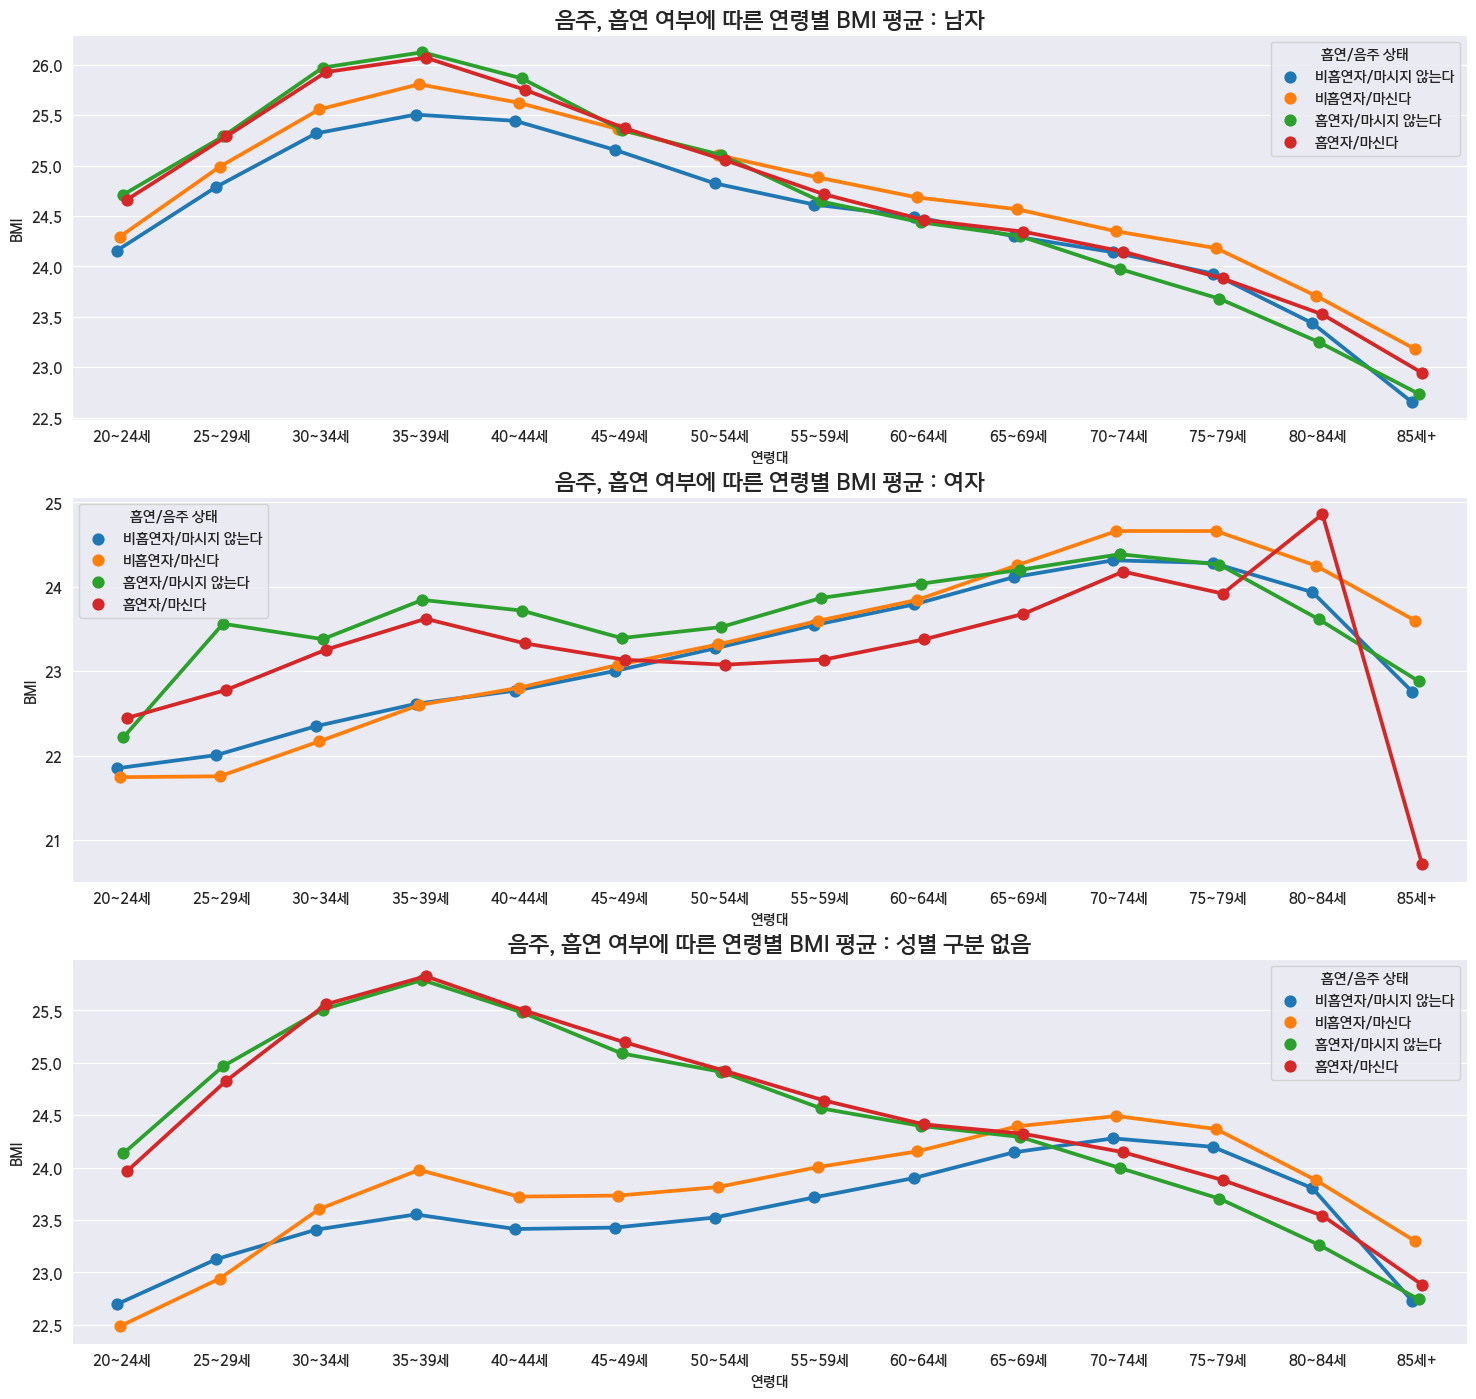

In [35]:
# 그래프
plt.figure(figsize=(18, 17))

plt.subplot(311)
plt.title('음주, 흡연 여부에 따른 연령별 BMI 평균 : 남자', fontsize=16)
sns.pointplot(x='연령대', y='BMI', hue='흡연_음주', data=man, dodge=True, capsize=.1)
plt.legend(title='흡연/음주 상태')

plt.subplot(312)
plt.title('음주, 흡연 여부에 따른 연령별 BMI 평균 : 여자', fontsize=16)
sns.pointplot(x='연령대', y='BMI', hue='흡연_음주', data=female, dodge=True, capsize=.1)
plt.legend(title='흡연/음주 상태')

plt.subplot(313)
plt.title('음주, 흡연 여부에 따른 연령별 BMI 평균 : 성별 구분 없음', fontsize=16)
sns.pointplot(x='연령대', y='BMI', hue='흡연_음주', data=no_mean, dodge=True, capsize=.1)
plt.legend(title='흡연/음주 상태')

plt.show()

    성별로 나눈 그래프와 성별로 나누지 않은 그래프를 비교했을 때
    남자의 그래프는 성별로 나누지 않은 그래프의 '흡연자/마신다', '흡연자/마시지 않는다' 선과 모양이 비슷했다.
    
    그러나 여자의 그래프는 성별로 나누지 않은 그래프의 '비흡연자/마신다', '비흡연자/마시지 않는다' 선과 모양이 비슷하면서도
    '흡연자/마신다'선의 경우 특이하게 85세+의 경우 급격하게 BMI평균이 떨어져 경향을 파악하기 어려웠다
    
    여자의 흡연율이 낮고 남자의 흡연율이 높기 때문에 성별 별로 특징이 다르게 나타난다.

### 5.3 흡연과 음주 둘다 안하는 사람과 그 외 BMI 비교

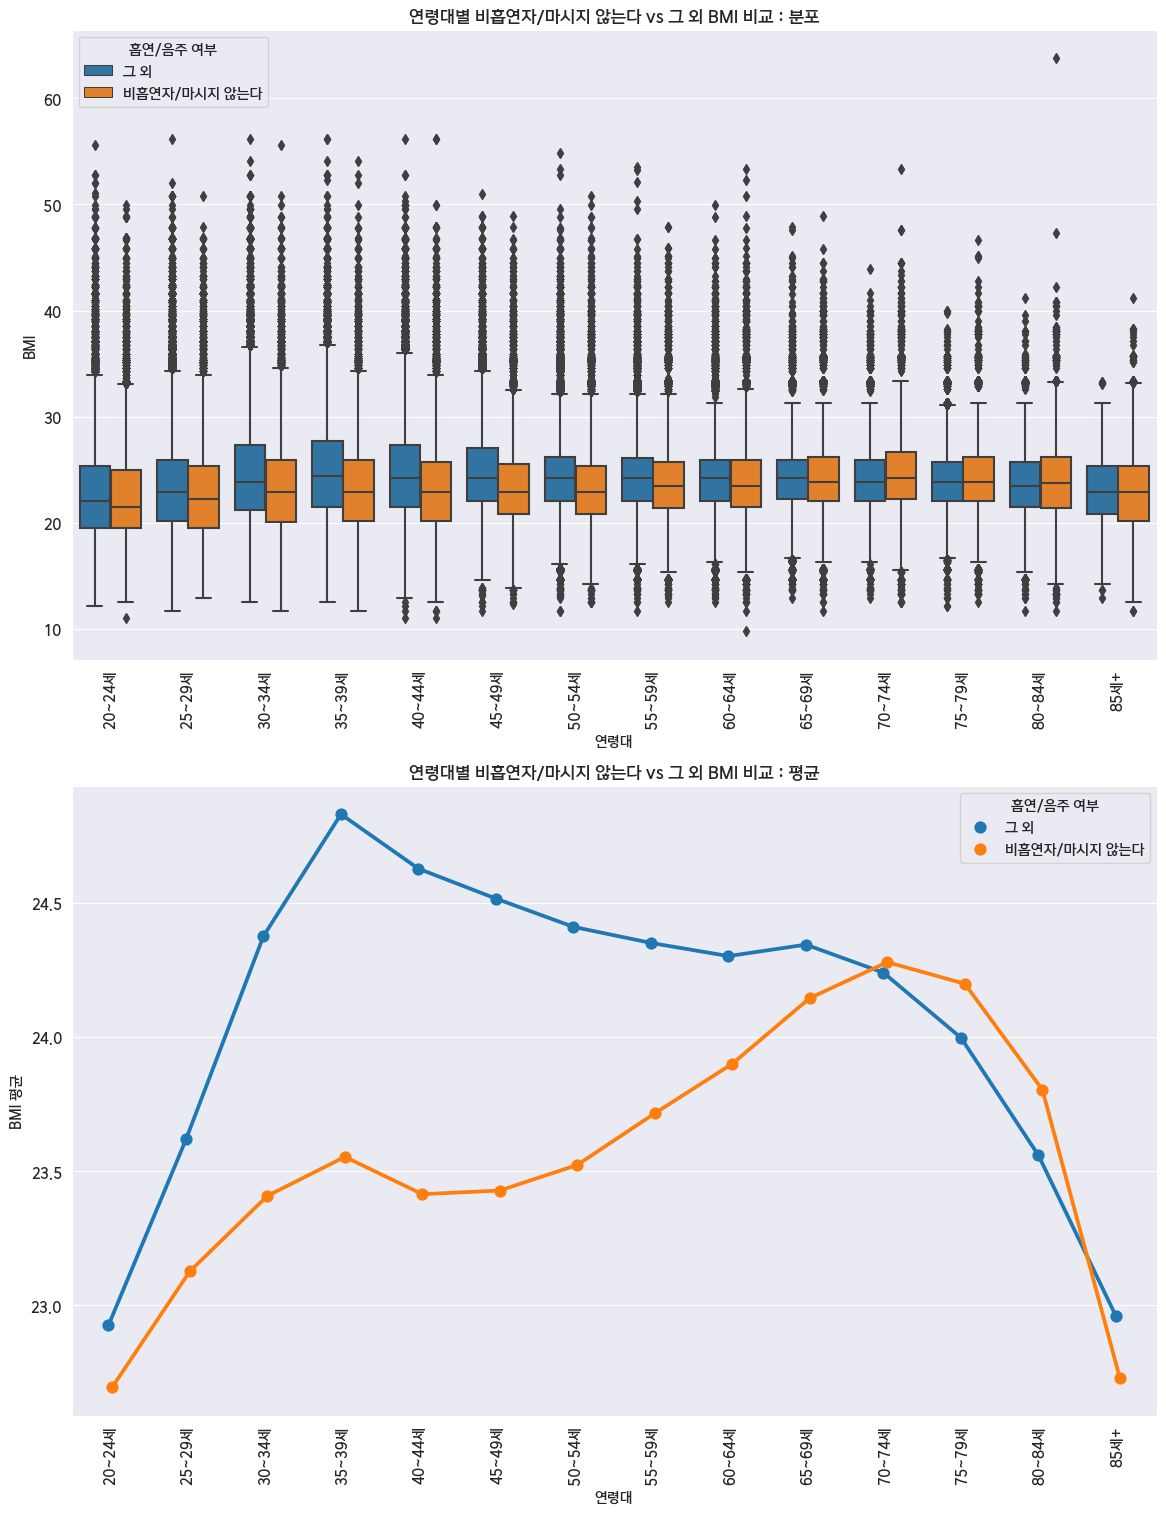

In [72]:
df_box = df_bmi.copy().sort_values('연령대')
df_box['흡연/음주 여부'] = df_box.apply(
    lambda row: '비흡연자/마시지 않는다' \
    if row['흡연상태'] == '비흡연자' and row['음주여부'] == '마시지 않는다' else '그 외', 
    axis=1
)
df_mean = df_box.groupby(["연령대", '흡연/음주 여부']).mean()['BMI'].reset_index()

plt.figure(figsize=(14, 18))

# 분포를 비교
plt.subplot(211)
sns.boxplot(x='연령대', y='BMI', hue='흡연/음주 여부', data=df_box)
plt.title('연령대별 비흡연자/마시지 않는다 vs 그 외 BMI 비교 : 분포')
plt.ylabel('BMI')
plt.xlabel('연령대')
plt.xticks(rotation='vertical')

# 평균을 비교
plt.subplot(212)
sns.pointplot(x='연령대', y='BMI', hue='흡연/음주 여부', data=df_mean, dodge=True, capsize=.1)
plt.title('연령대별 비흡연자/마시지 않는다 vs 그 외 BMI 비교 : 평균')
plt.ylabel('BMI 평균')
plt.xlabel('연령대')
plt.xticks(rotation='vertical')

plt.show()

### 5.4 연령대 별 BMI 변화

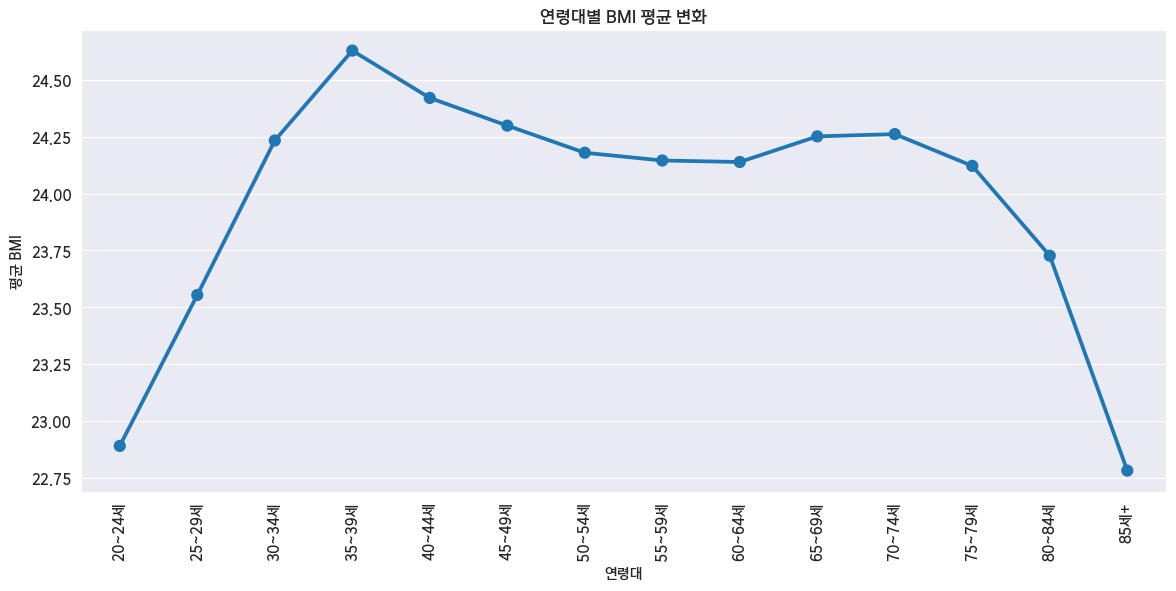

In [37]:
df_group = df_bmi.groupby(["연령대"]).mean()['BMI']

plt.figure(figsize=(14, 6))
sns.pointplot(x="연령대", y="BMI", data=df_group.reset_index(), dodge=True, capsize=.1)
plt.title("연령대별 BMI 평균 변화")
plt.ylabel("평균 BMI")
plt.xlabel("연령대")
plt.xticks(rotation='vertical')

plt.show()

## 6. 가설에 대한 결론

### 6.1 가설에 따른 분석 결과

- 5.1의 '음주, 흡연 여부에 따른 연령별 BMI 평균' 그래프를 보면,  
    전체적으로 흡연 및 음주 여부에 따라 BMI 평균의 차이는 있었으나, 연령대별로 큰 차이가 존재 했다.<br>
<br>    
- 5.2의 성별로 분리한 '음주, 흡연 여부에 따른 연령별 BMI 평균' 그래프에서,  
    남자와 여자 모두 흡연 및 음주 여부에 따라 BMI의 평균 차이는 일부 존재했으나 특정 연령대에서만 두드러지게 나타났다.<br>
<br>
- 5.3의 '연령대별 비흡연자/마시지 않는다 vs 그 외 BMI 비교 : 분포' 그래프에서,  
    비흡연자/비음주자 그룹이 다른 그룹에 비해 BMI가 낮게 나타났으나 연령대별로 일관되게 나타나진 않았다<br>
<br>
- 5.4의 '연령대별 BMI 평균 변화' 그래프를 보면 연령대 별로 BMI 평균의 차이가 큰 것을 알 수 있다.

### 6.2 결론

- **흡연과 음주만으로는 정확하게 BMI를 구분해낼 수 없다.**<br>
<br>
- 초기에는 음주 여부와 흡연 상태에 따라 BMI가 뚜렷이 구분될 것이라 예상했으나, 이는 편견이었다는 것을 확인했다.<br><br>
- 연령대별로 BMI에 차이가 있었고, 본 데이터만으로는 설명할 수 없는 경향들이 나타났다.<br>
<br>
- **BMI는 음주, 흡연, 연령대 외에도 식습관, 운동량, 유전 등 여러 가지 복합적 요소에 영향을 받는다.**

---------------------------------------------------------------------------

## 7. 부록

### 7.1 흡연상태, 음주여부에 따른 BMI 분포 (부록(1) 참고)

흡연상태, 음주여부에 따른 BMI 분포를 그려보았으나 유의미한 인사이트를 얻기가 어려워 생략

### 7.2 데이터 샘플링 1 (부록(2) 참고)

연령별로 1000명씩 남자 14000명, 여자 14000명을 랜덤하게 추출하여 다시 분석을 해보았으나<br>
5.1 '연령대별 흡연상태와 음주여부에 따른 BMI 평균치 비교' 그래프와 경향이 비슷하여 생략

### 7.3 데이터 샘플링 2 (부록(3) 참고)

4.3.3 '성별에 따른 흡연상태 비율' 그래프에서 흡연자 비율이 남자가 압도적으로 높았고,<br>
5.2 '음주, 흡연 여부에 따른 연령별 BMI 평균 : 남자' 그래프의 경향이 성별로 나누지 않은 그래프의 흡연자의 경향과 비슷하다는 점,<br>
또 4.4.2 '성별 별 비만분류' 그래프에서 남자의 비만 비율이 높았던 것으로 미루어 보았을 때,<br>
<br>
남자 데이터의 영향을 많이 받아 그래프에 편향성이 생겼을 수 있으므로<br>
남녀의 흡연자, 비흡연자 수를 맞추는 샘플링을 진행하여 다시 결과를 확인해보았다.<br>

### 7.4 전체 비만분류 비율 (부록(4) 참고)

전체 비만분류 비율을 파이차트로 출력하였다.